# Students

Leonardo Chiarioni  
A0001145863  
leonardo.chiarioni@studio.unibo.it  

Nicolas Cridlig  
A16002193  
nicolasivan.cridlig@studio.unibo.it  

Federico Marchi  
A0001118908  
federico.marchi9@studio.unibo.it  

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

# Set up the runtime
The usual suspects...

## Imports
We set CUBLAS_WORKSPACE_CONFIG to ":16:8" (limits performance) or ":4096:8" (uses ~24MiB extra GPU memory) before importing libraries to ensure reproducibility.
Source: https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from torch.optim import Adam, AdamW, SGD, lr_scheduler
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T, datasets, models
from torchsummary import summary

## Acceleration

In [2]:
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}!")

Using cuda!


## Determinism
We make every effort to have reproducible results. This slows single run performance but facilitates experimentation.
Source: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed=42
g = torch.Generator()
g.manual_seed(seed)
fix_random(seed)

## Load Dataset 

In [4]:
# Check if GroceryStoreDataset already exists
if os.path.isdir("GroceryStoreDataset"):
    print("Found dataset. Skipping download.")
else:
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Found dataset. Skipping download.


## Labels to names
We can map between labels and class names for human readability as well as to understand what our classes are.

In [5]:
classes_csv_path = 'GroceryStoreDataset/dataset/classes.csv'
classes_df = pd.read_csv(classes_csv_path, header=0, names=['Class_Name', 'Class_ID', 'Coarse_Class_Name', 'Coarse_Class_ID', 'Iconic_Image', 'Product_Description'])

# Extract names and labels
class_names = classes_df['Coarse_Class_Name'].tolist()
class_labels = classes_df['Coarse_Class_ID'].tolist()

# Create a mapping from label to name
label_to_name = {label: name for label, name in zip(class_labels, class_names)}
print(label_to_name)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Kiwi', 4: 'Lemon', 5: 'Lime', 6: 'Mango', 7: 'Melon', 8: 'Nectarine', 9: 'Orange', 10: 'Papaya', 11: 'Passion-Fruit', 12: 'Peach', 13: 'Pear', 14: 'Pineapple', 15: 'Plum', 16: 'Pomegranate', 17: 'Red-Grapefruit', 18: 'Satsumas', 19: 'Juice', 20: 'Milk', 21: 'Oatghurt', 22: 'Oat-Milk', 23: 'Sour-Cream', 24: 'Sour-Milk', 25: 'Soyghurt', 26: 'Soy-Milk', 27: 'Yoghurt', 28: 'Asparagus', 29: 'Aubergine', 30: 'Cabbage', 31: 'Carrots', 32: 'Cucumber', 33: 'Garlic', 34: 'Ginger', 35: 'Leek', 36: 'Mushroom', 37: 'Onion', 38: 'Pepper', 39: 'Potato', 40: 'Red-Beet', 41: 'Tomato', 42: 'Zucchini'}


## Dataloader
Define a `torch.utils.data.Dataset` class to access the data. This `Dataset` class is the starting point of the assignment: we use it and build everything else around it.

In [6]:
class GroceryStoreDataset(Dataset):
    '''
    A custom dataset class for loading and processing images from the GroceryStore dataset.

    Args:
        split (str): The split of the dataset to use ('train', 'val', 'test'). The split determines 
                      which set of images and labels are loaded from the dataset.
        transform (Optional[callable], default=None): A torchvision.transforms.Compose to apply to the images.

    Attributes:
        root (Path): The root directory where the dataset is stored.
        split (str): The dataset split ('train', 'val', 'test').
        paths (List[str]): A list of file paths for the images in the dataset.
        labels (List[int]): A list of corresponding labels for each image.
        transform (Optional[callable], default=None): A torchvision.transforms.Compose to apply to the images.
    '''
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Plotting
It is important to plot our data for several reasons.
- to verify any transformations have the desired effects 
- to understand its distribution
- to visualize training
- to better understand how the network performs at test time

In [7]:
def unclip_image(img):
    '''
    Avoids clipping of the image after normalization, useful for plotting purposes.

    Args:
        img (torch.Tensor)
    Returns:
        torch.Tensor
    '''
    if torch.min(img) < 0 or torch.max(img) > 1:
        # Normalize the image data to the range [0, 1]
        min_val = torch.min(img)
        max_val = torch.max(img)

        # Avoid division by zero
        if max_val - min_val != 0:
            img = (img - min_val) / (max_val - min_val)
        else:
            img = np.zeros_like(img)  # Handle the case where the image is a constant value

    return img


def plot_data(dataset, size=None, normalization=False, augmentation=False):
    '''
    Visualize the dataset using image-label pairs.

    Args:
        dataset (GroceryStoreDataset): Image-label dataloader which inherits from torch.utils.data.Dataset.
        size (Optional[int], default=None): Side length of the square image.
        normalization (Boolean, default=False): Whether the images are in the range [0,1] or [0,255].
        augmentation (Boolean, default=False): Whether the dataset contains synthetic images.

    Returns:
        None: Plots the data to console.
    '''
    if not size and not normalization and not augmentation:
        print("No transformation applied to data")
    else:
        print("Transformation applied to data: "
        +(f"\nsize = {(size,size)}" if size else "")
        +(f"\nnormalization = {normalization}" if normalization else "")
        +(f"\naugmentation = {augmentation}" if augmentation else "")
        )

    _, ax = plt.subplots(1, 4, figsize=(12, 5))

    np.random.seed(seed)
    indices = np.random.choice(len(dataset), size=4, replace=False)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        ax[i].imshow(unclip_image(img).permute(1, 2, 0))
        ax[i].set_title(label_to_name.get(label))
        ax[i].axis("off")

def plot_distribution(datasets, splits=("train", "val", "test")):
    '''
    Visualize the dataset using a bar chart.

    Args:
        dataset (List[GroceryStoreDataset]): Image-label dataloaders which inherit from torch.utils.data.Dataset.
        splits (Tuple, default=("train", "val", "test")): Labels for the dataloaders.

    Returns:
        (Tuple): The class weights for each dataset.
    '''
    class_weights_list = []
    
    plt.figure(figsize=(12, 6))
    
    num_classes = len(np.bincount(datasets[0].labels)) 
    bar_width = 0.25 
    x = np.arange(num_classes) 

    # Loop over datasets and corresponding split names
    for i, (dataset, split) in enumerate(zip(datasets, splits)):
        labels = dataset.labels
        counts = np.bincount(labels, minlength=num_classes)  # Ensure consistent length for all counts
        class_weights = 1. / np.sqrt(counts+1e-9) # Numerical stability
        class_weights = torch.FloatTensor(class_weights)
        class_weights_list.append(class_weights)
        
        # Plot each dataset's distribution as a separate bar with an offset
        plt.bar(x + i * bar_width, counts, width=bar_width, label=split)
    
    # Configure plot details
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Datasets')
    plt.xticks(x + bar_width, np.arange(num_classes))  # Center x-ticks for each class
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return tuple(class_weights_list)

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, epochs, lrs):
    '''
    Plots the training and validation losses, accuracies, and learning rates over epochs.

    This function generates two subplots:
    - The first subplot shows the training and validation losses, along with the learning rate.
    - The second subplot shows the training and validation accuracies, along with the learning rate.

    Args:
        train_losses (list): A list of training losses over the epochs.
        val_losses (list): A list of validation losses over the epochs.
        train_accuracies (list): A list of training accuracies over the epochs.
        val_accuracies (list): A list of validation accuracies over the epochs.
        epochs (int): The total number of epochs during training.
        lrs (list): A list of learning rates over the epochs.

    Returns:
        None: Displays a plot with training and validation performance metrics.
    '''
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)

    # Left Plot (Loss and Learning Rate)
    ax1 = ax[0].twinx()
    ax[0].plot(range(1, epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    ax1.plot(range(1, epochs + 1), lrs, label='Learning Rate', linestyle='dashed', color='grey')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax1.set_ylabel('Learning Rate')
    ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    ax[0].grid(True)
    # Combine legends and move outside the plot
    lines, labels = ax[0].get_legend_handles_labels()
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax[0].legend(lines + lines1, labels + labels1, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    # Right Plot (Accuracy and Learning Rate)
    ax2 = ax[1].twinx()
    ax[1].plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    ax[1].plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    ax2.plot(range(1, epochs + 1), lrs, label='Learning Rate', linestyle='dashed', color='grey')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax2.set_ylabel('Learning Rate')
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    ax[1].grid(True)
    # Combine legends and move outside the plot
    lines, labels = ax[1].get_legend_handles_labels()
    lines1, labels1 = ax2.get_legend_handles_labels()
    ax[1].legend(lines + lines1, labels + labels1, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.show()

def plot_per_class_accuracy(model, best_params, dl):
    '''
    Visualize the class accuracy of the model using a bar chart.

    Args:
        model (nn.Module): An instance of a model which inherits the torch neural network model.
        best_params (dict): The model parameters (weights) at the epoch with the best validation accuracy.
        dl (GroceryStoreDataset): Testing dataloader which inherits from torch.utils.data.Dataset.

    Returns:
        None: Displays a bar plot with per class accuracies.
    '''
    print("IMPLEMENT PLOT PER CLASS ACCURACY!!!")
    pass

## Training and Inference

In [8]:
def ncorrect(scores, y):
    '''
    Counts the number of correct predictions.

    Args:
        scores (torch.Tensor): A tensor of shape (N, C) with raw scores for each class.
        y (torch.Tensor): A tensor of shape (N,) containing the true labels

    Returns:
        torch.Tensor: Count of correct predictions as a single integer tensor.
    '''
    y_hat = torch.argmax(scores, -1)  # Predict class with the highest score for each sample
    return (y_hat == y).sum()  # Count the correct predictions by comparing to true labels

def accuracy(scores, y):
    '''
    Calculates the accuracy as the ratio of correct predictions to total predictions.

    Args:
        scores (torch.Tensor): A tensor of shape (N, C) with raw scores for each class.
        y (torch.Tensor): A tensor of shape (N,) containing the true labels

    Returns:
        torch.Tensor: Accuracy as a single tensor between zero and one.
    '''
    correct = ncorrect(scores, y)  # Number of correct predictions
    return correct.true_divide(y.shape[0])  # Normalize by total number of samples

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, label_smoothing=0.0, scheduler=False, max_no_improvement_epochs=10, class_weights=None):
    '''
    General purpose training loop for the model.

    Args:
        model (nn.Module): An instance of a model which inherits the torch neural network model.
        train_dl (GroceryStoreDataset): Training dataloader which inherits from torch.utils.data.Dataset.
        epochs (int): Maximum number of training epochs.
        opt (Optimizer): The PyTorch optimizer used by gradient descent.
        val_dl (Optional[GroceryStoreDataset], default=None): Validation dataloader which inherits from torch.utils.data.Dataset.
        verbose (Boolean, default=False): Print training progress and final results to terminal.
        label_smoothing (float, default=0.0): Amount of label smoothing to apply. A value between 0 and 1.
        scheduler (Boolean, default=False): Learning rate scheduler.
        max_no_improvement_epochs (int, default=10): Also known as patience or early stopping. No improvement after this many epochs halts training.
        class_weights (Optional[torch.Tensor], default=None): Biases some classes in the loss more than others.

    Returns:
        Tuple:
        - best_val_acc (float): Best validation accuracy achieved during training.
        - best_params (dict): The model parameters (weights) at the epoch with the best validation accuracy.
        - best_epoch (int): The epoch number where the best validation accuracy was achieved.
    '''
    fix_random(seed=seed)

    # Initialize variables to track the best model accuracy and parameters
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    # Define loss function with optional class weights and label smoothing
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
    no_improvement_epochs = 0  # Counter for early stopping

    # Lists to record training and validation metrics over epochs
    train_losses, val_losses, train_accuracies, val_accuracies, lrs = [], [], [], [], []

    # Set the device to GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Iterate over epochs
    for e in tqdm(range(1, epochs + 1)):
        model.train()  # Set model to training mode

        # Initialize counters for tracking training loss and accuracy
        train_loss = 0
        train_samples = 0
        train_acc = 0

        # Record the learning rate for the current epoch
        lrs.append(opt.param_groups[0]['lr'])

        # Iterate over the training data loader
        for train_data in train_dl:
            imgs = train_data[0].to(device)  # Move images to device
            labels = train_data[1].to(device)  # Move labels to device

            scores = model(imgs)  # Forward pass: Compute model scores
            loss = criterion(scores, labels)  # Compute loss
            train_loss += loss.item() * imgs.shape[0]  # Accumulate weighted loss
            train_samples += imgs.shape[0]  # Update sample count
            train_acc += ncorrect(scores, labels).item()  # Accumulate correct predictions

            # Perform backpropagation and optimizer step
            opt.zero_grad()  # Clear gradients
            loss.backward()  # Compute gradients
            opt.step()  # Update model parameters

        # Step the scheduler if it is specified
        if scheduler != False:
            scheduler.step()

        # Calculate average training accuracy and loss
        train_acc /= train_samples
        train_loss /= train_samples

        # Record training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                # Iterate over the validation data loader
                for val_data in val_dl:
                    imgs = val_data[0].to(device)  # Move images to device
                    labels = val_data[1].to(device)  # Move labels to device

                    val_scores = model(imgs)  # Forward pass: Compute model scores
                    val_loss += criterion(val_scores, labels).item() * imgs.shape[0]  # Accumulate weighted loss
                    val_samples += imgs.shape[0]  # Update sample count
                    val_acc += ncorrect(val_scores, labels).item()  # Accumulate correct predictions

                # Calculate average validation accuracy and loss
                val_acc /= val_samples
                val_loss /= val_samples

                # Record validation metrics
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            # Save the model if it has the best validation accuracy so far
            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()  # Save model parameters
                torch.save(best_params, "best_model.pth")  # Save model to file
                best_epoch = e
                no_improvement_epochs = 0  # Reset early stopping counter
            else:
                no_improvement_epochs += 1  # Increment early stopping counter

        # Print progress if verbose mode is enabled
        if verbose and (e - 1) % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" +
                  ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

        # Early stopping if no improvement for a set number of epochs
        if no_improvement_epochs >= max_no_improvement_epochs:
            print(f"Early stopping at epoch {e}")
            break

    # Print the best epoch and accuracy if validation is used
    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.3f}")

    # Plot training and validation results
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, e, lrs)

    return best_val_acc, best_params, best_epoch  # Return the best validation accuracy, model parameters, and epoch

def test_model(model, best_params, dl, plot=True):
    '''
    Evaluate the model on a test dataset by accuracy.

    Args:
        model (nn.Module): An instance of a model which inherits the torch neural network model.
        best_params (dict): The model parameters (weights) at the epoch with the best validation accuracy.
        dl (GroceryStoreDataset): Testing dataloader which inherits from torch.utils.data.Dataset.
        plot (Boolean, default=True): Also plot the per class bar chart.

    Returns:
        None: The function prints the test accuracy but does not return any value.
    '''
    model.load_state_dict(best_params)  # Load best model parameters
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        correct = 0
        total = 0
        for imgs, labels in dl:
            imgs = imgs.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device
            outputs = model(imgs)  # Forward pass: Compute model outputs
            total += imgs.shape[0]  # Update sample count
            correct += ncorrect(outputs, labels).item()  # Accumulate correct predictions

        # Print test accuracy
        print(f'Test Accuracy: {(100 * correct / total):.2f}%')

    if plot: plot_per_class_accuracy(model, best_params, dl)


## Statistics

In [9]:
def mean_std(dataset):
    '''
    Calculate the per-channel mean and standard deviation for a dataset of images.

    Args:
        dataset (torch.utils.data.Dataset): A dataset where each sample is a tuple of an image tensor and its label.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - mean (numpy.ndarray): Per-channel mean of the dataset (C,).
            - std (numpy.ndarray): Per-channel standard deviation of the dataset (C,).
            
    Note:
        - The dataset is assumed to be composed of images with shape (C, H, W), where C is the number of channels, H is the height, and W is the width.
        - The function computes the mean and standard deviation for each channel across the entire dataset.
        - This function expects the images to be in the range [0, 255] for correct standard deviation calculation.
    '''
    # Initialize variables to calculate the sum and sum of squares for each channel
    mean_sum = 0
    std_sum = 0
    n_pixels = 0

    # Iterate through the dataset
    for image, _ in dataset:
        # Convert image to numpy array and reshape to (C, H*W)
        image = image.numpy() / 255.0
        c, h, w = image.shape

        # Update total pixel count
        n_pixels += h * w

        # Sum the channel-wise means
        mean_sum += image.sum(axis=(1, 2))

        # Sum the squared differences for std
        std_sum += (image ** 2).sum(axis=(1, 2))

    # Calculate mean and std
    mean = mean_sum / n_pixels
    std = np.sqrt(std_sum / n_pixels - mean ** 2)

    return mean, std

# Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Loading the dataset: let's study it!
Let's split the dataset into train, validation and test set and try to look for some insights. This section is important for choosing our data preprocessing steps.

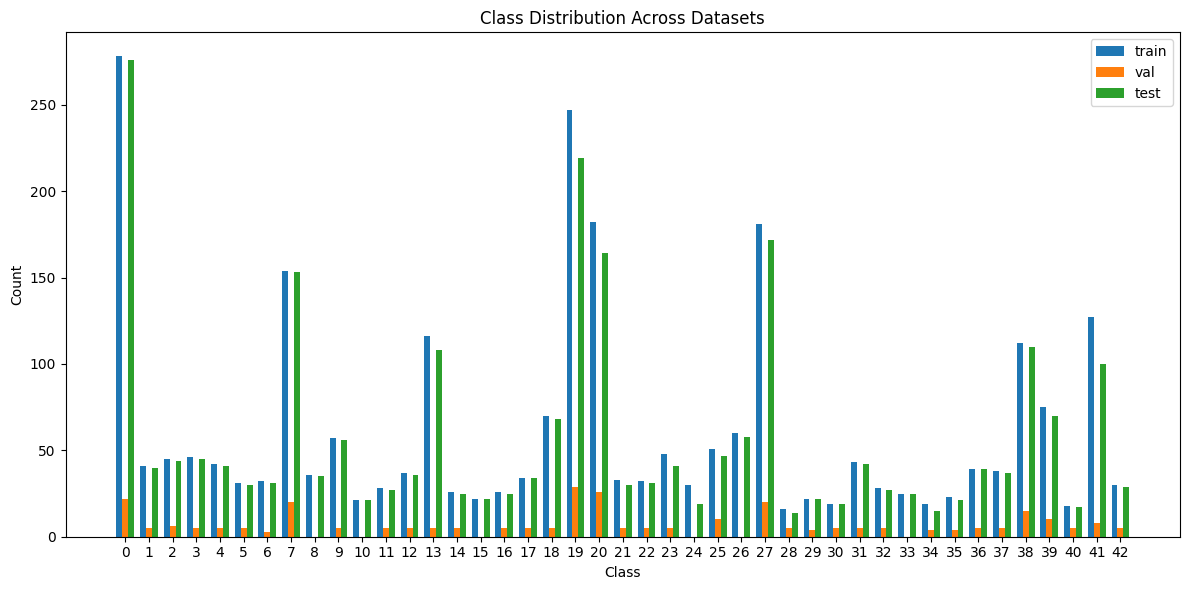

In [10]:
# Create the dataset objects
train_dataset = GroceryStoreDataset(split='train', transform=T.ToTensor())
val_dataset = GroceryStoreDataset(split='val', transform=T.ToTensor())
test_dataset = GroceryStoreDataset(split='test', transform=T.ToTensor())

# Plot the distribution of the data
class_weights = plot_distribution([train_dataset, val_dataset, test_dataset], splits=("train", "val", "test"))

We conclude that the training and test dataset have a similar distribution, which is good, since it will help our model generalize to the unseen data. Regrettably, the validation dataset does not include some rare classes (8, 10, 15, 24, 26, 33) which makes it less trustworthy as a substitute for predicted model performance during training. 

We tried training (INSERT THE PERFORMANCE DIFFERENCE AND ON WHICH MODEL) by weighing the less frequent classes more heavily, but this reduced performance. We conclude this is since the test data has the same distribution we were just biasing the model towards less likely detections. However, given the class frequency imbalance, we must be sure to plot the class accuracy as well as the total accuracy when evaluating our mode. All this being said, we see that our dataset is a unbalanced and our network might learn that some labels are more likely than others. We will try regularization techniques to see if they mitigate this.
To investigate further, we plot some example images.

No transformation applied to data


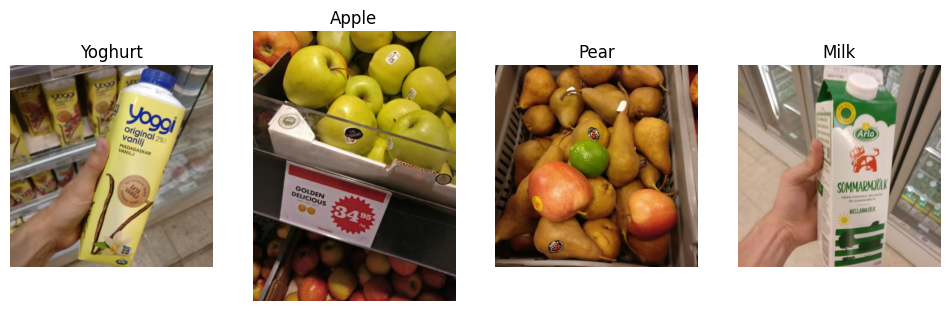

In [11]:
plot_data(train_dataset)

**Classification**  
In image classification, an algorithm tells us the category to which an image belongs.
Not only is our dataset made of images with different resolution but the subject is not always in the center! This behavior, coined photographer's bias, helped early CV neural networks achieve higher performance, but will not help us here.

## Transforming the dataset!
1) We will apply a transformation to lower the resolution of the input images to make training faster. 
2) As part of the process, we make all the data samples square (same length and width). This comes with the downside of warping shapes, but as you can see on the apples, the effect is not huge and this simplifies the model further. 
3) Moreover, we need to normalize our dataset in order to have zero mean and unitary variance, to avoid gradient saturation and improving the training in general. We know this from Section 4.3 in LeCun et al. (1998) in [Efficient BackProp](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf). To do so, we can compute mean and standard deviation of our training dataset! At test time we will then use the same ones since we expect that the distribution of the training set is representative of the test set as well.  

We have ideas to fix the input resolution to more than 64x64 pixels by resizing the image and can eventually try to apply different data transformation later on, like shape invariant cropping, to see how it impacts the performance. However, we wish to see how the model performs already without making the pipeline more complex.

Transformation applied to data: 
size = (64, 64)
normalization = True


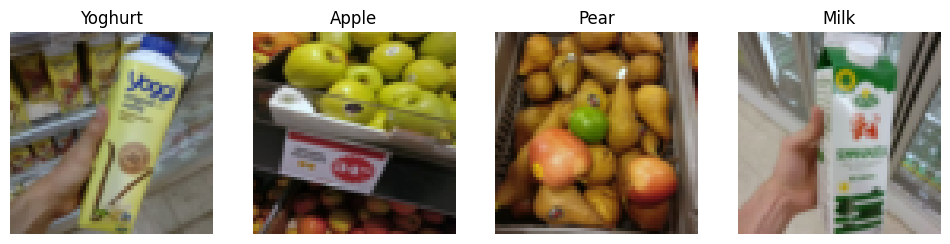

In [12]:
mean, std = mean_std(train_dataset)

size = 64

transform = T.Compose([
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

plot_data(train_dataset, size=size, normalization=True)

We need to wrap our sets in a DataLoader structure, which will help us on training and testing our model. To do so, we also need to specify a batch size. To make sure we fit in the GPU memory, let's set it to 128. This is the value in the famous ALexNet CNN paper “ImageNet Classification with Deep Convolutional Neural Networks”, NeurIPS 2012.

In [13]:
batch_size = 128
num_workers=1

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

n_classes = train_dataset.get_num_classes()

## Training settings
To understand and compare different versions of our model, let's fix some hyperparameters that will be used during training:  
- max_epochs = 50
- learning_rate = $ 10^{-3} $

Our models will be trained with **early stopping** for a maximum amount of 50 epochs: if our model can't improve accuracy on the validation set for 5 epochs in a row the training will be aborted. 50 epochs is chosen to prevent very long training times. However, if a model were to continue converging up to this maximum, we would consider raising it and justify this. The learning rate was selected according to Goodfellow et al. in Deep Learning (MIT Press, 2016) which has a chapter on hyperparamters: https://www.deeplearningbook.org/contents/guidelines.html
Empically, learning rates for stochastic gradient descent (SGD) and its variants are in the range of $ 10^{-3} $ to $ 10^{-1} $. We will use a modern optimizer, Adam, and select a smaller value, around $ 10^{-3} $.
We can be eventually modified this static learning rate through a schedule or perform grid search to compare its effect on our particular model. We admit that choosing the optimizer and setting the learning rate is hard to justify thoroughly, there is also some intuitions build from looking at many other models. There is probably some bias there, as well.

In [14]:
learning_rate = 10**(-3)
max_epochs = 50
models_summary = {} # store models for comparison

# TODO ADD TENSORBOARD OR SOME OTHER NICE VISUALIZER
- try other optimizers than ADAM
- try other activation functions than RELU (leakyReLU)

# Fully Connected Network
**Model 0**  
From our studies, we know that this task will benefit heavily from the inductive biases present in convolutional networks. However, it pays to put the theory to the test, so we try a FCN as the starting point.
- Input dimension is channels by width by height
- We split the architecture into a feature extractor backbone, which will become a CNN, and a FCN classifier, which will remain
- To lower the dimensionality, we chose factors greater than or equal to 1/2 because it seems a good compromise between too aggressive and not enough
- Last layer in the classifier is a bottleneck layer with an output dimension equal to the number of classes (43)

In [15]:
class Model0(nn.Module):
    '''
    A model made of vanilla fully connected layers.
    '''
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
        nn.Linear(3*64*64, 8192),
        nn.ReLU(inplace=True),

        nn.Linear(8192, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 2048),
        nn.ReLU(inplace=True),

        nn.Linear(2048, 1024),
        nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.features(x)
        x = self.classifier(x)
        return x

    def get_name(self):
        return "Model0"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 674.632 - train acc 0.038 - valid loss 4.024 - valid acc 0.068
Epoch 6: train loss 2.377 - train acc 0.289 - valid loss 2.923 - valid acc 0.182
Early stopping at epoch 9
Best epoch 4, best acc 0.230


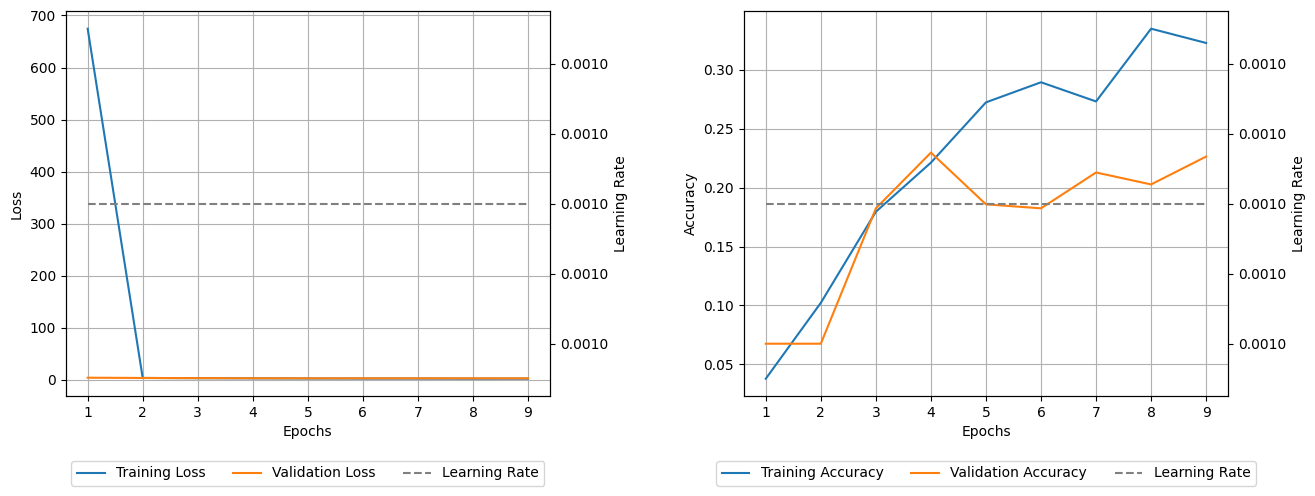

In [16]:
# Initialize the model, loss function, and optimizer
model = Model0(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5)

In [17]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': None,
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

We reached a baseline accuracy of 23%. The training loss is immense at first, it is clear that gradient descent has to expend a lot of effort to understand images without the help of the suitable architecture.

## Convolutional Neural Network
**Model 1**  
The idea is to implement a [VGG](https://arxiv.org/abs/1409.1556)-like architecture: a stack of stages that process activations at the same spatial resolution.  
Each stage is made of:
- 3x3 convolution
- Relu activation
- 2x2 Maxpooling, with stride 2  

This architecture turned out to be very simple and effective: application of small kernel with a maxpooling operator that halves the spatial dimensions and doubles the channel dimension. After the feature extractor we put a 2 fully-connected layers classifier with 1024 neurons each. Let's start from this basic model and augment it in order to improve it's capacity and validation accuracy!  

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [18]:
class Model1(nn.Module):
  '''
  A VGG inspired model.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 32x32x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 16x16x128

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 8x8x256

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 4x4x512
    )
    self.classifier = nn.Sequential(
        nn.Linear(4*4*512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x) # Feature extractor backbone
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model1"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 20.528 - train acc 0.106 - valid loss 3.420 - valid acc 0.122
Epoch 6: train loss 0.768 - train acc 0.749 - valid loss 3.369 - valid acc 0.280
Epoch 11: train loss 0.237 - train acc 0.923 - valid loss 4.683 - valid acc 0.284
Early stopping at epoch 12
Best epoch 7, best acc 0.341


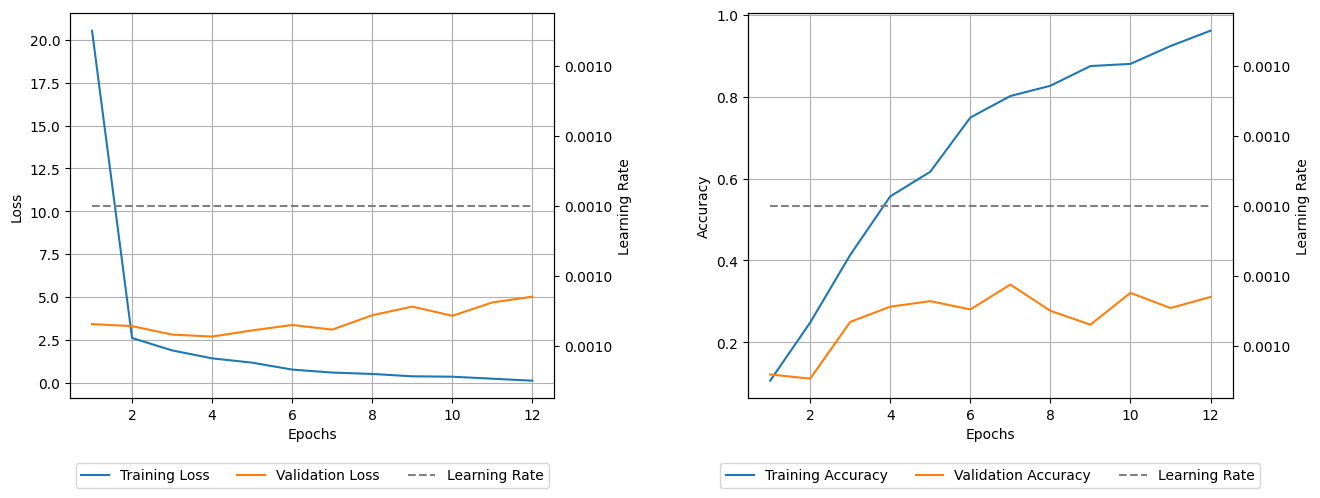

In [19]:
# Initialize the model, loss function, and optimizer
model = Model1(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5)

In [20]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': None,
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

We reached a validation accuracy of 34.1% which is far from our goal, and we can see from the plots that our model is suffering from overfitting during training since the validation loss is increasing. We must try to improve the generalization of our model, maybe by introducing some forms of regularizations. We could try by **introducing dropout regularization** on the FC layers and see how it works!

## Dropout regularization
[Nitish Srivastava et al., “Dropout: A Simple Way to Prevent Neural Networks from Overfitting”, JMLR 2015.](https://jmlr.org/papers/v15/srivastava14a.html)  

Randomly drop units (along with their connections) from the neural network during training, preventing units from co-adapting too much.  
Let's apply dropout with p=0.5 to our fully connected layers.

In [21]:
class Model2(nn.Module):
  '''
  A model inspired by VGG with dropout regularization in the classifier.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 32x32x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 16x16x128

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 8x8x256

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 4x4x512
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5), # <-------------
        nn.Linear(4*4*512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5), # <-------------
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model2"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 9.432 - train acc 0.092 - valid loss 3.259 - valid acc 0.176
Epoch 6: train loss 1.567 - train acc 0.512 - valid loss 2.291 - valid acc 0.341
Epoch 11: train loss 0.750 - train acc 0.752 - valid loss 2.917 - valid acc 0.291
Early stopping at epoch 11
Best epoch 6, best acc 0.341


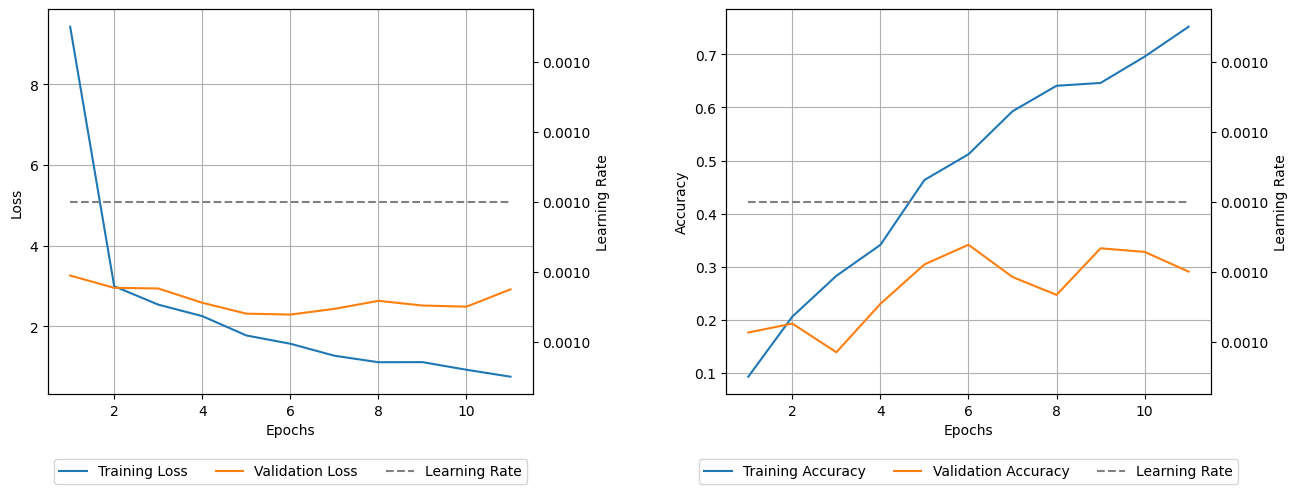

In [22]:
# Initialize the model, loss function, and optimizer
model = Model2(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5
)


In [23]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout',
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

We have not obtained an improvement on the validation accuracy it stayed the same at 34.1%! Regularization still had a positive impact on generalizing over unseen data, in our opinions, since the validation loss is lower. We believe overfitting is still a problem though: since we're dealing with image classification, we could try to average out along the channel dimension at the interface between the convolutional and fully-connected layer, through **global average pooling**.  
This can be beneficial by:
- reducing the number of parameters of the fully convolutional layer (of an $H*W=16$ factor);
- may improve generalization since we're just interested in an high response of a feature (namely the class of the image) rather than its specific position on the image.

## Global Average Pooling  
[Lin et al., “Network in network”, ICLR 2014](https://arxiv.org/abs/1312.4400)  

Pytorch implements an adaptive [average pooling operator](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), which allows us to deal with input images of arbitrary resolution.

In [24]:
class Model3(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization in the classifier and global average pooling on the final feature extractor.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 32x32x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # out: 16x16x128

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 8x8x256

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)) # out: 1x512# <-------------
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model3"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 4.978 - train acc 0.108 - valid loss 3.293 - valid acc 0.132
Epoch 6: train loss 2.086 - train acc 0.363 - valid loss 2.420 - valid acc 0.253
Epoch 11: train loss 1.439 - train acc 0.539 - valid loss 2.516 - valid acc 0.257
Epoch 16: train loss 0.976 - train acc 0.677 - valid loss 3.039 - valid acc 0.280
Early stopping at epoch 19
Best epoch 14, best acc 0.338


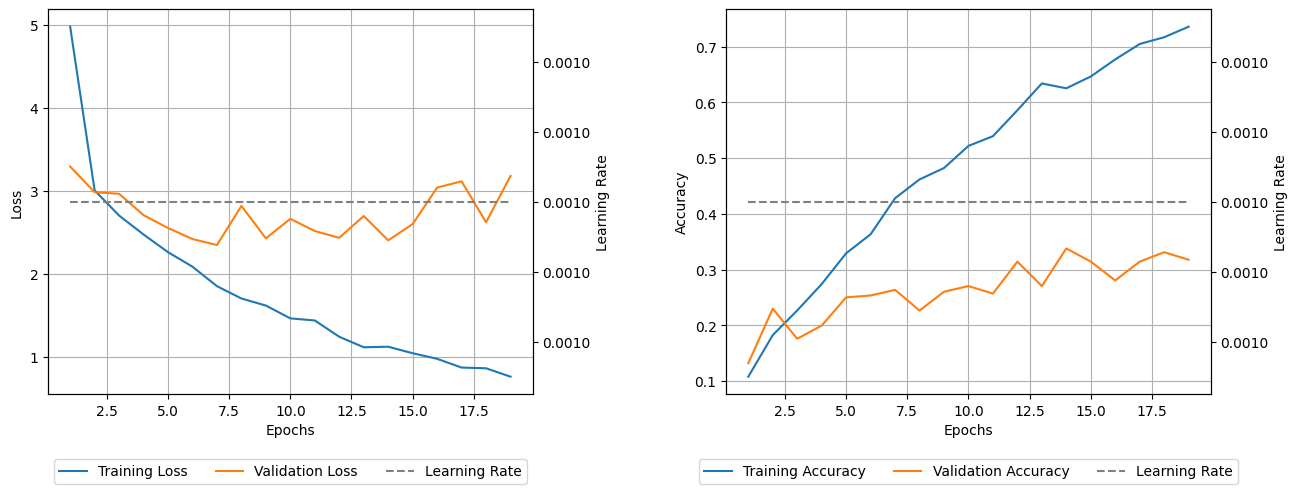

In [25]:
# Initialize the model, loss function, and optimizer
model = Model3(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoc = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5
)

In [26]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

As expected, average pooling layer has improved generalization a lot! +11% accuracy on validation set and, as we can see from the plots, the training is way slower over the epochs and model's overfitting on training data is not really reached (not even 80% accuracy on the training set!)  
We are getting close to our goal, but there are still many interesting regularization techniques that are worth to try!

## Batch Normalization
[Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)  
Solving the internal covariate shift (change in the distribution of each layer's input during training) by normalizing the layer's input along the batch dimension.

Let's add batch normalization to every convolutional layer.  
While surfing the net and [discussion forums](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/?rdt=63945), there are different opinions on whether to put the batchnorm layer **before** or **after** the relu.  
- Batchnorm **before** non linearity: it generally performs better and it's often chosen;
- Batchnorm **after** non linearity: regularize better the data in terms of internal covariate shift since relu's output is truncated to only positive values.  

Since we are conducting a study, we want to try them both to see which one performs better.

### Before ReLu

In [27]:
class Model4(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization in the classifier and global average pooling on the final feature extractor. Every layer of the feature extractor has batch normalization before the activation function.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- Before ReLU
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- Before ReLU
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- Before ReLU
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- Before ReLU
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model4"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.853 - train acc 0.231 - valid loss 2.649 - valid acc 0.240
Epoch 6: train loss 1.085 - train acc 0.625 - valid loss 2.267 - valid acc 0.331
Early stopping at epoch 10
Best epoch 5, best acc 0.456


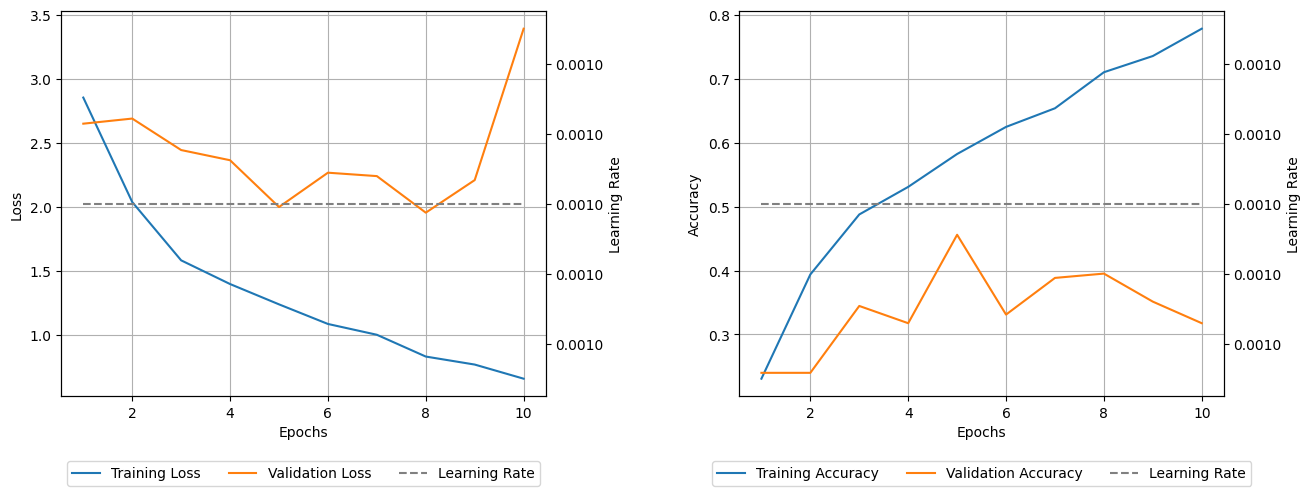

In [28]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5
)

In [29]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

We improved the accuracy on the validation of around 7%, which set this as the best model so far. The plots suggest that we're skipping a lot of local minimas! This is bad because we might skip promising minima that may lead to a more accurate model. We can try to push it a little bit further with a **learning rate scheduler**, but let's see first what happens if we put batchnorm layer after the relu!

### After ReLu

In [30]:
class Model5(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization in the classifier and global average pooling on the final feature extractor. Every layer of the feature extractor has batch normalization after the activation function.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- After Relu
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- After Relu
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- After Relu
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <------------- After Relu
    nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model5"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.595 - train acc 0.290 - valid loss 2.667 - valid acc 0.270
Epoch 6: train loss 0.712 - train acc 0.772 - valid loss 2.096 - valid acc 0.419
Epoch 11: train loss 0.232 - train acc 0.924 - valid loss 1.927 - valid acc 0.510
Epoch 16: train loss 0.110 - train acc 0.966 - valid loss 2.119 - valid acc 0.530
Epoch 21: train loss 0.049 - train acc 0.987 - valid loss 2.084 - valid acc 0.537
Epoch 26: train loss 0.064 - train acc 0.981 - valid loss 2.546 - valid acc 0.497
Early stopping at epoch 27
Best epoch 22, best acc 0.557


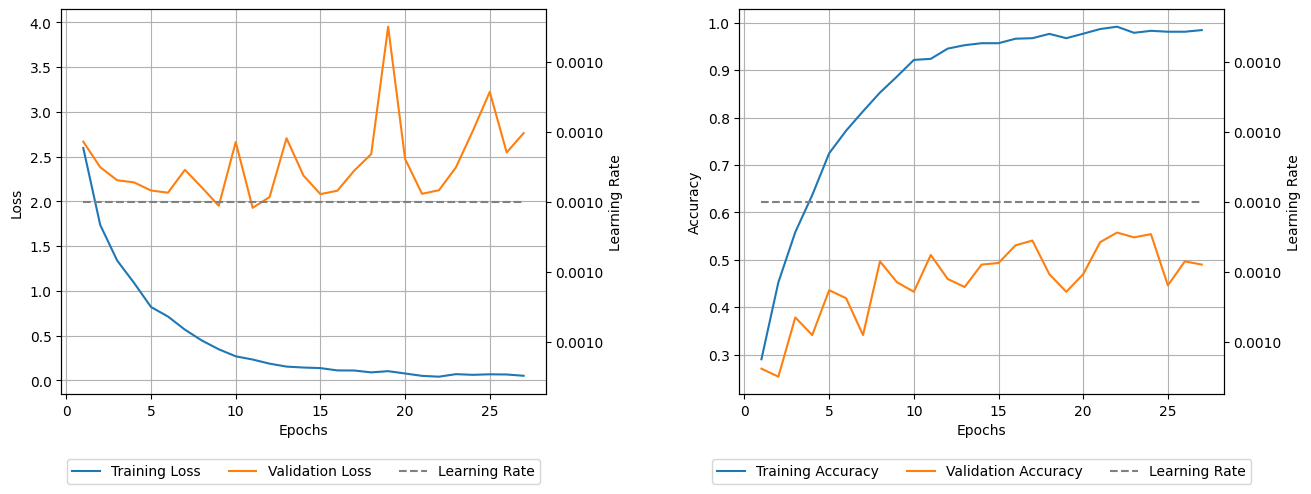

In [31]:
# Initialize the model, loss function, and optimizer
model = Model5(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    max_no_improvement_epochs=5
)

Batch norm after ReLu has brought us almost to the same accuracy, but we can see that the plots are far more regular wrt before! This might be the case because we're normalizing the data after the non linearity, which makes more sense if batchnorm is trying to solve the internal covariate shift!

In [32]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

## Learning rate scheduler
Since we are skipping local minima, let's try by implementing a simple learning rate scheduler! We will:  
- First use **step scheduler** to train Model4 (batchnorm before ReLu), by halving the learning rate every **4 epochs**;
- Then use **step scheduler** to train Model5 (batchnorm after ReLu), by halving the learning rate every **6 epochs**;

The choice of the halving period is based on the plot we saw before: at around that epoch the loss started to rise again, meaning that we have might skipped a minima!

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.890 - train acc 0.210 - valid loss 3.624 - valid acc 0.267
Epoch 6: train loss 1.023 - train acc 0.641 - valid loss 1.796 - valid acc 0.416
Epoch 11: train loss 0.574 - train acc 0.819 - valid loss 1.693 - valid acc 0.500
Epoch 16: train loss 0.435 - train acc 0.870 - valid loss 1.638 - valid acc 0.544
Epoch 21: train loss 0.323 - train acc 0.909 - valid loss 1.519 - valid acc 0.561
Epoch 26: train loss 0.321 - train acc 0.913 - valid loss 1.503 - valid acc 0.557
Early stopping at epoch 27
Best epoch 22, best acc 0.571


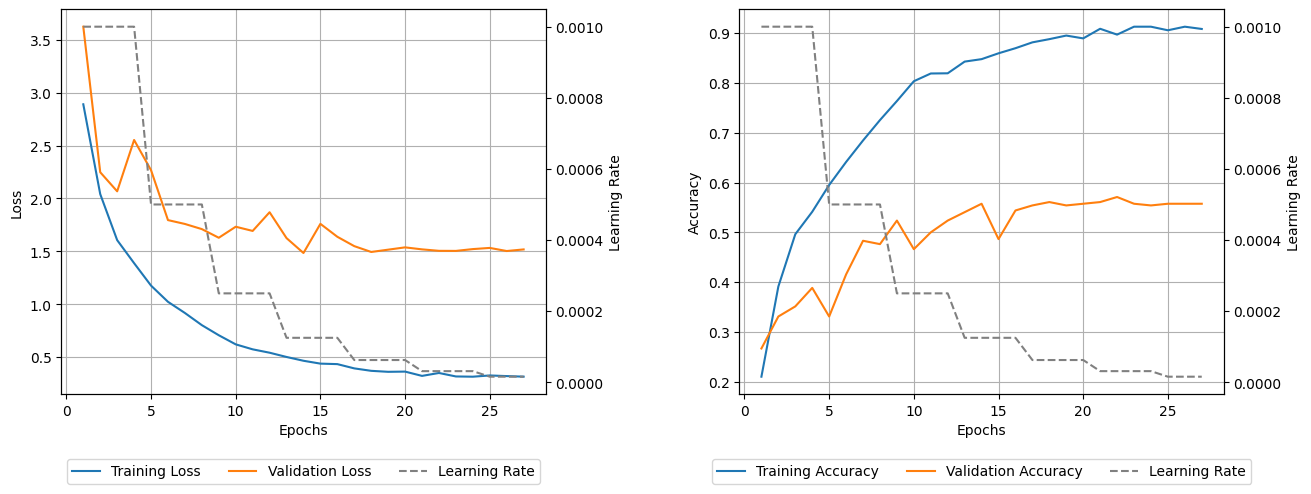

In [33]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5) # <---------------------------

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    max_no_improvement_epochs=5
)

Our intuition was correct and we've finally reached our goal! By implementing a scheduler we've been able to improve the accuracy and finding a better minima, obtaining $60.5$% on the validation set!

In [34]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

Let's save the model parameters.

In [35]:
torch.save(best_params, "my_best_model.pth")

Let's apply the step learning rate scheduler also to Model5, this time halving the learning rate every 6 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.641 - train acc 0.277 - valid loss 2.360 - valid acc 0.372
Epoch 6: train loss 0.703 - train acc 0.766 - valid loss 1.903 - valid acc 0.405
Epoch 11: train loss 0.224 - train acc 0.937 - valid loss 1.860 - valid acc 0.534
Epoch 16: train loss 0.092 - train acc 0.980 - valid loss 1.940 - valid acc 0.544
Epoch 21: train loss 0.048 - train acc 0.991 - valid loss 1.900 - valid acc 0.534
Early stopping at epoch 22
Best epoch 17, best acc 0.568


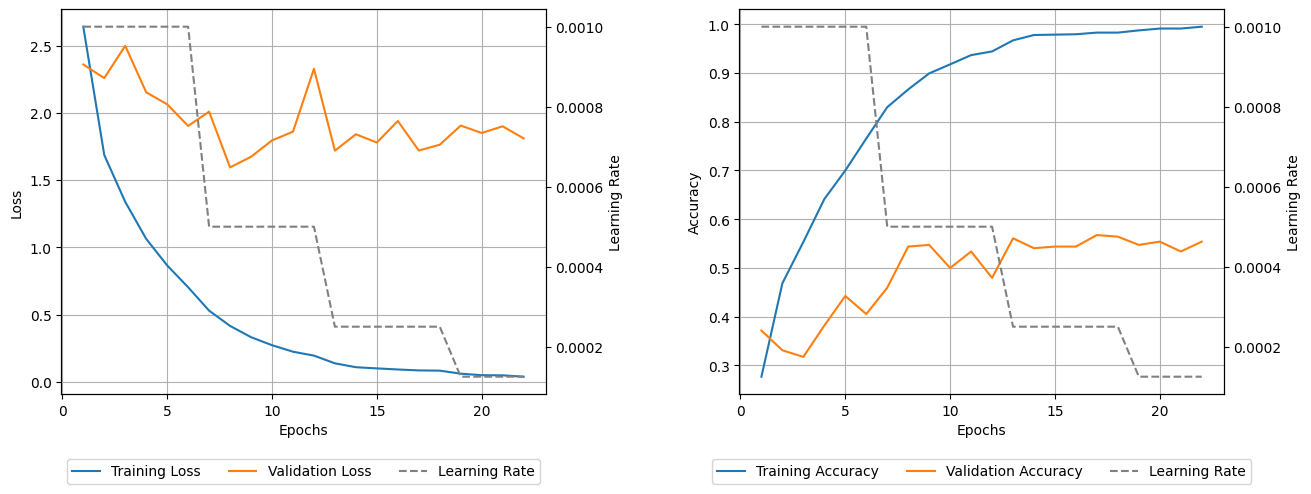

In [36]:
# Initialize the model, loss function, and optimizer
model = Model5(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5) # <---------------------------

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    max_no_improvement_epochs=5
)

The simple learning rate scheduler didn't work on this Model and we are stuck on the same validation accuracy. We could investigate a more sophisticated learning rate scheduler, but since we have achieved our goal we consider ourselves satisfied!

In [37]:
params = {
    'model': model.get_name(),
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

## Input Resolution
We have learned how to optimize our model. Now, we try to increase performance by throwing more data at our best model. We will create dataloaders with a higher image resolution and train Model 4 once more.

In [ ]:
size=224

train_dataset_224 = GroceryStoreDataset(split='train', transform=transform)
val_dataset_224 = GroceryStoreDataset(split='val', transform=transform)
test_dataset__224 = GroceryStoreDataset(split='test', transform=transform)

plot_data(train_dataset_224, size=size, normalization=True)

train_dl_224 = DataLoader(
    train_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dl_224 = DataLoader(
    val_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dl_224 = DataLoader(
    test_dataset__224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5) # <---------------------------

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    max_no_improvement_epochs=5
)

In [ ]:
params = {
    'model': model.get_name()+'_224',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
models_summary[model.get_name] = params

## Testing our best model
Let's test our model on the test set and see the accuracy.

In [38]:
model = Model4(n_classes=n_classes).to(device)
params = torch.load("my_best_model.pth", weights_only=True)
test_model(model, params, test_dl)

Test Accuracy: 65.63%
IMPLEMENT PLOT PER CLASS ACCURACY!!!


The accuracy is even higher than with the one on the validation set! We believe this is due to the unrepresented classes in validation which the model has successfully learned during training.

In [39]:
models_summary_df = pd.DataFrame.from_dict(models_summary)
models_summary_df
#models_summary_df.reset_index(drop=True).sort_values(by='validation accuracy', ascending=False)

,"<bound method Model0.get_name of Model0(\n (features): Sequential(\n (0): Linear(in_features=12288, out_features=8192, bias=True)\n (1): ReLU(inplace=True)\n (2): Linear(in_features=8192, out_features=4096, bias=True)\n (3): ReLU(inplace=True)\n (4): Linear(in_features=4096, out_features=2048, bias=True)\n (5): ReLU(inplace=True)\n (6): Linear(in_features=2048, out_features=1024, bias=True)\n (7): ReLU(inplace=True)\n )\n (classifier): Sequential(\n (0): Linear(in_features=1024, out_features=512, bias=True)\n (1): ReLU(inplace=True)\n (2): Linear(in_features=512, out_features=43, bias=True)\n )\n)>","<bound method Model1.get_name of Model1(\n (features): Sequential(\n (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (1): ReLU(inplace=True)\n (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (4): ReLU(inplace=True)\n (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (7): ReLU(inplace=True)\n (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (10): ReLU(inplace=True)\n (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n )\n (classifier): Sequential(\n (0): Linear(in_features=8192, out_features=1024, bias=True)\n (1): ReLU(inplace=True)\n (2): Linear(in_features=1024, out_features=43, bias=True)\n )\n)>","<bound method Model2.get_name of Model2(\n (features): Sequential(\n (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (1): ReLU(inplace=True)\n (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (4): ReLU(inplace=True)\n (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (7): ReLU(inplace=True)\n (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (10): ReLU(inplace=True)\n (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n )\n (classifier): Sequential(\n (0): Dropout(p=0.5, inplace=False)\n (1): Linear(in_features=8192, out_features=1024, bias=True)\n (2): ReLU(inplace=True)\n (3): Dropout(p=0.5, inplace=False)\n (4): Linear(in_features=1024, out_features=43, bias=True)\n )\n)>","<bound method Model3.get_name of Model3(\n (features): Sequential(\n (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (1): ReLU(inplace=True)\n (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (4): ReLU(inplace=True)\n (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (7): ReLU(inplace=True)\n (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (10): ReLU(inplace=True)\n (11): AdaptiveAvgPool2d(output_size=(1, 1))\n )\n (classifier): Sequential(\n (0): Dropout(p=0.5, inplace=False)\n (1): Linear(in_features=512, out_features=1024, bias=True)\n (2): ReLU(inplace=True)\n (3): Dropout(p=0.5, inplace=False)\n (4): Linear(in_features=1024, out_features=43, bias=True)\n )\n)>","<bound method Model4.get_name of Model4(\n (features): Sequential(\n (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n (2): ReLU(inplace=True)\n (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

## Conclusions
In our study we've shown that starting from a simple model we've improved generalization and reduced overfitting by mainly using **regularization methods**.  
In particular:
- Average pooling at the interface between convolutional and fully connected layers improved consistently the generalization;
- Batch norm layers seems to be more beneficial if applied before ReLu, even though the losses show a less regular plot with respect to the one applied after ReLu;
- Learning rate scheduler was necessary to avoid skipping promising minima and allowed us to reach our goal.

Other things we could have experimented to improve the performances:
- Weights decay;
- Label smoothing;
- Data augmentation;
- More advanced learning rate schedulers.

# Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [40]:
def freeze_layers_but(model, layers_to_unfreeze):
    total_parameters, trainable_parameters = 0, 0
    if len(layers_to_unfreeze) == 0:
        print('All layers are unfrozen')
        for param in model.parameters():
            total_parameters += param.numel()
        trainable_parameters = total_parameters

    else:
        for name, child in model.named_children():
            if name in layers_to_unfreeze:
                print(name + ' is unfrozen')
                for param in child.parameters():
                    param.requires_grad = True
                    trainable_parameters += param.numel()
                    total_parameters += param.numel()
            else:
                for param in child.parameters():
                    param.requires_grad = False
                    total_parameters += param.numel()

    print(f"Total parameters count: {total_parameters}")
    print(f"Trainable parameters count: {trainable_parameters}")

In [41]:
resnet_summary = []

## 1. Let's instantiate a ResNet-18 model with default weights and let's fine-tune it with the best hyperparameters used for our best model.  
We set:
- resolution 64x64 pixel
- batch size = 64
- learning rate = 0.001
- max_epoch = 50
- learning rate schedule halving every 4 epochs
- **No freezed layers**: let's try to make the model adjusts all its parameters to the new dataset.

In [42]:
size = 64

transform = T.Compose([
    T.ToTensor(),
    T.Resize((size,size)),
    T.Normalize(mean=mean, std=std)
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

n_classes = train_dataset.get_num_classes()

# Hyperparameters
learning_rate = 0.001
max_epochs = 50

## Adjusting the model to our dataset:
One thing we have to do before starting with the fine-tuning, is to change the output layer to the number of classes we have in our dataset!

All layers are unfrozen
Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.520 - train acc 0.583 - valid loss 2.210 - valid acc 0.426
Epoch 6: train loss 0.036 - train acc 0.991 - valid loss 1.662 - valid acc 0.581
Epoch 11: train loss 0.009 - train acc 0.998 - valid loss 1.657 - valid acc 0.591
Early stopping at epoch 14
Best epoch 9, best acc 0.618


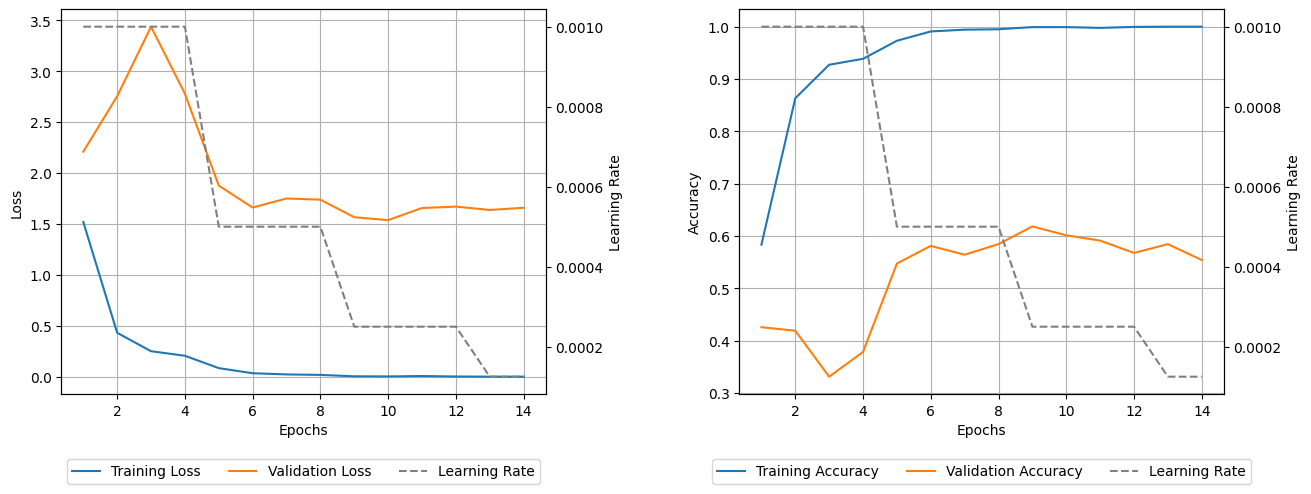

In [43]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
freeze_layers_but(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    max_no_improvement_epochs=5
)


The ResNet18 model trained using the same "recipe" as before showed the same results on the validation set in terms of accuracy. Here we've let the model to learn all its parameters, making the pre-training of the model not as useful as it could be.  
Moreover, **ResNet18 is much more deeper** than our 4 convlayers VGG-like model: it could make the best use of an higher resolution with more low level details!  
The idea is to try to implement the ideas listed at the end of our architecture, which weren't implemented because the goal was reached. Let's see their impact on this new architecture!

In [44]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': None,
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

## 2. Tuning the hyperparameters


What we could try to do is to exploit the deepness of our architecture to learn more detailed and specific features of our dataset. Indeed, ResNet18 is a much deeper and more complex architecture which might be able to maximize the use of an augmented dataset.  

At https://medium.com/@zeyneptufekci.etu/resnet-with-data-augmentation-71d3031cd4b3#:~:text=improved%20accuracy%20result is explained how data augmentation on ResNet has improved the accuracy, and the ResNet18 itself has been trained on Imagenet1k with data augmentation techinques.  

Indeed, ResNet18 has been trained on **images with 224x224 pixels**, so let's stick with this resolution from now on!
Let's try it out by introducing random variation of the viewpoints of the image: **random rotations** and **flipping** horizontally.

In [45]:
size = 224

transform_train = T.Compose([
    T.ToTensor(),
    T.Resize((size,size)), # set image resolution to (224,224) #
    T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally #
    T.RandomRotation(30),      # Randomly rotate the image by 30 degrees #
    T.Normalize(mean=mean, std=std)

])
transform_test = T.Compose([
    T.ToTensor(),
    T.Resize((size,size)),
    T.Normalize(mean=mean, std=std)
])

train_dataset = GroceryStoreDataset(split='train', transform=transform_train)
val_dataset = GroceryStoreDataset(split='val', transform=transform_test)
test_dataset = GroceryStoreDataset(split='test', transform=transform_test)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

All layers are unfrozen
Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.085 - train acc 0.701 - valid loss 1.630 - valid acc 0.541
Epoch 6: train loss 0.030 - train acc 0.994 - valid loss 0.830 - valid acc 0.760
Epoch 11: train loss 0.005 - train acc 1.000 - valid loss 0.743 - valid acc 0.774
Epoch 16: train loss 0.003 - train acc 1.000 - valid loss 0.713 - valid acc 0.774
Early stopping at epoch 17
Best epoch 12, best acc 0.797


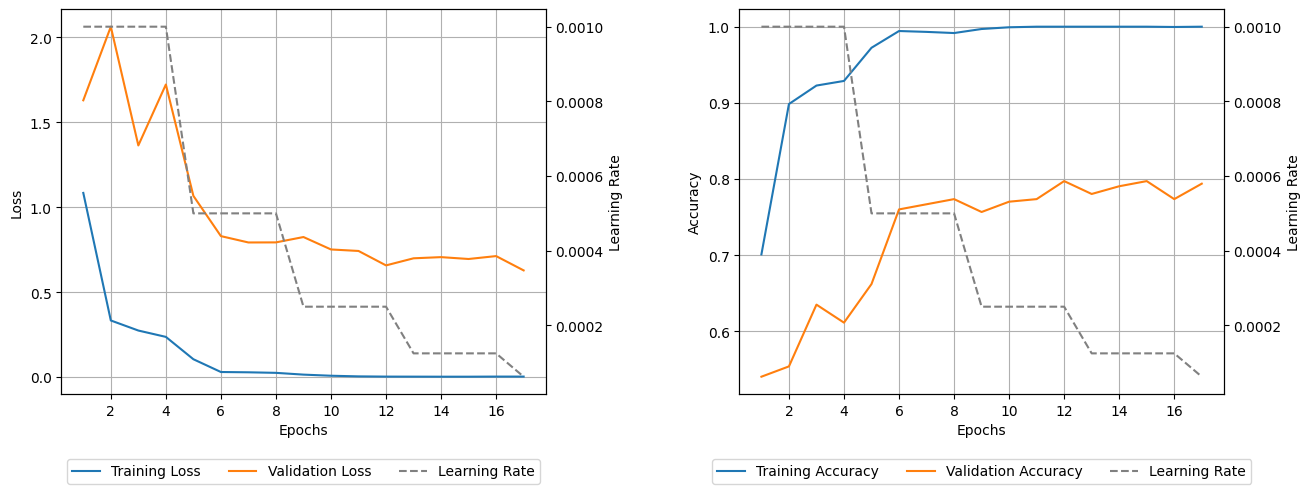

In [46]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
freeze_layers_but(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    max_no_improvement_epochs=5

)


As predicted, our model improved amazingly by applying transformations on the dataset! +23% on validation accuracy.  
Training time (3x slower) increased consistently since we've increased the resolution of the dataset.  

Very nice results, but is that all?

In [47]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation',
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

Let's try by introducing some new regularization to our model to increase it's capacity. We can try by adding a **label_smoothing** to the Cross Entropy Loss and **weight decay** to our optimizer.
For the latter, let's use the **AdamW implementation**.

All layers are unfrozen
Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.661 - train acc 0.699 - valid loss 2.370 - valid acc 0.500
Epoch 6: train loss 0.748 - train acc 0.997 - valid loss 1.294 - valid acc 0.818
Epoch 11: train loss 0.713 - train acc 1.000 - valid loss 1.173 - valid acc 0.858
Epoch 16: train loss 0.704 - train acc 1.000 - valid loss 1.201 - valid acc 0.858
Epoch 21: train loss 0.702 - train acc 1.000 - valid loss 1.161 - valid acc 0.865
Epoch 26: train loss 0.701 - train acc 1.000 - valid loss 1.157 - valid acc 0.868
Early stopping at epoch 29
Best epoch 24, best acc 0.872


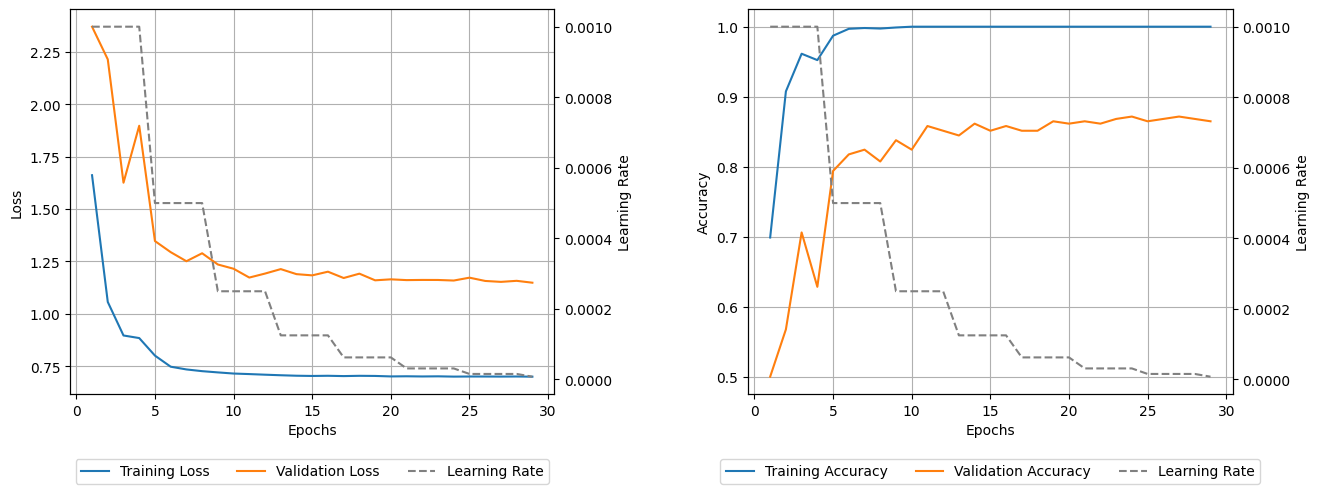

In [48]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
freeze_layers_but(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01) # <--------------------------
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1, # <--------------------------
    scheduler = scheduler,
    max_no_improvement_epochs=5

)


No improvements in terms of accuracy, but look at the plots! It seems that thee regularization have stabilized a lot the training and we achieved the same results in half of the epochs.

In [49]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation, label smoothing, weight decay',
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

We are satisfied with the results achieved so far for the training from scratch part.  
Let's save the parameters!

### Test the model

In [50]:
torch.save(best_params, "resnet_best_model.pth")

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task

model = model.to(device)

In [52]:
test_model(model, best_params, test_dl)

Test Accuracy: 88.77%
IMPLEMENT PLOT PER CLASS ACCURACY!!!


We have obtained a similar accuracy also on the test set!

## What if we freeze some layers?
So far we have fine-tuned every layer of our model, but our dataset made of fruit is quite simple and the pre-training on imagenet should have been enough for the model to extract valuable information from it. What we want to do is to freeze some layers and unfreeze some other to make the best use of transfer learning.   
Our final experiment consists in 3 trials:
- freeze everything but the fc layer;
- freeze everything but layer4 and the fc layer;
- freeze everything but layer3, layer4 and the fc layer.

### Freeze everything but the fully connected layer

fc is unfrozen
Total parameters count: 11198571
Trainable parameters count: 22059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.927 - train acc 0.287 - valid loss 2.555 - valid acc 0.365
Epoch 6: train loss 1.241 - train acc 0.895 - valid loss 1.735 - valid acc 0.662
Epoch 11: train loss 1.135 - train acc 0.915 - valid loss 1.672 - valid acc 0.699
Early stopping at epoch 15
Best epoch 10, best acc 0.713


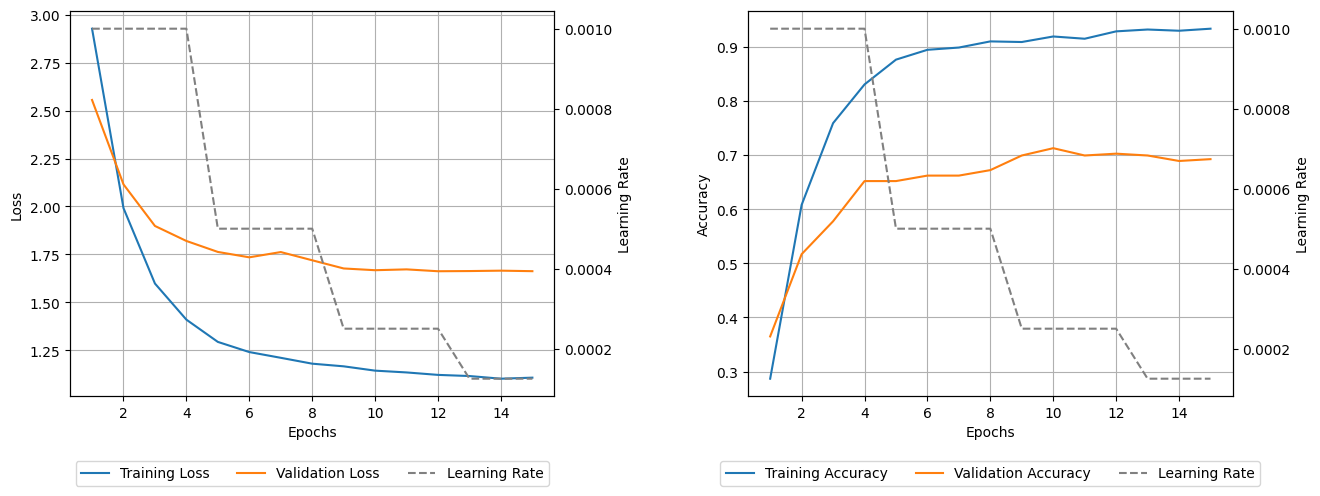

In [53]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
freeze_layers_but(model, ['fc']) # <--------------------------
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,
    max_no_improvement_epochs=5

)


By only fine-tuning the fully connected layer we have reached an accuracy of 66%, better than our model implemented model, even though the input resolution is different.

This means that the convolutional layers are able to extract valuable information from any image that compose our dataset, but we're a bit far from the results we obtained with fine-tuning all the parameters from scratch.  
Let's try by unfreezing also some of the convolutional layers, which should be responsible for extracting data-specific features!

In [54]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation, label smoothing, weight decay',
    'unfreezed layers': '[fc]',
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

### Freeze everything but layer4 and the fully connected layer

layer4 is unfrozen
fc is unfrozen
Total parameters count: 11198571
Trainable parameters count: 8415787


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.494 - train acc 0.761 - valid loss 1.533 - valid acc 0.753
Epoch 6: train loss 0.740 - train acc 0.999 - valid loss 1.233 - valid acc 0.848
Epoch 11: train loss 0.716 - train acc 1.000 - valid loss 1.218 - valid acc 0.858
Epoch 16: train loss 0.706 - train acc 1.000 - valid loss 1.178 - valid acc 0.885
Epoch 21: train loss 0.704 - train acc 1.000 - valid loss 1.181 - valid acc 0.865
Early stopping at epoch 21
Best epoch 16, best acc 0.885


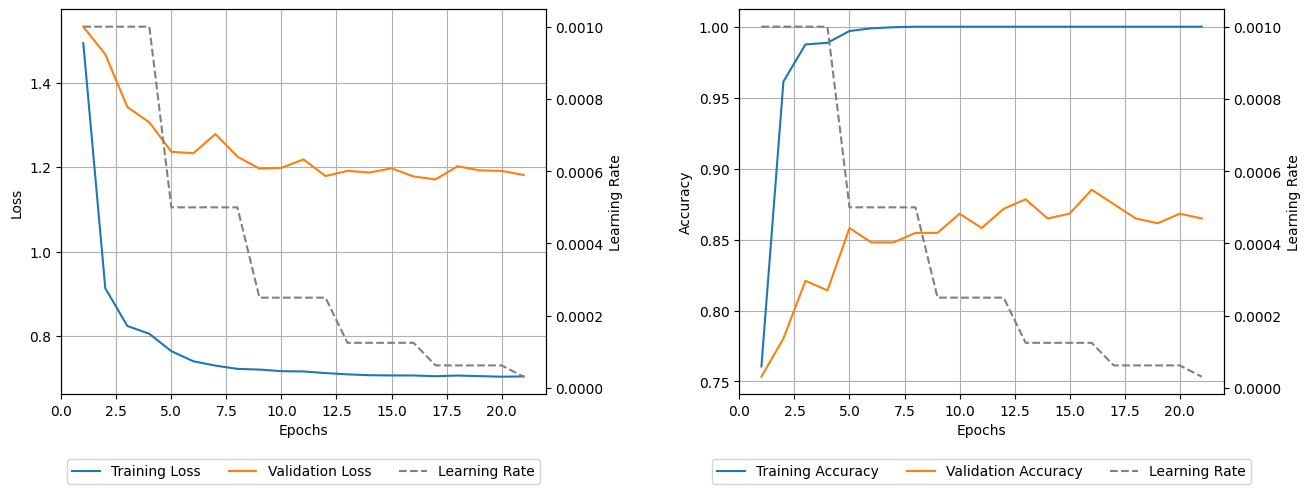

In [55]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
freeze_layers_but(model, ['layer4','fc']) # <--------------------------
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,
    max_no_improvement_epochs=5
)


We have obtained better results than by training everything from scratch! 87.5%  
This suggests that we could have some inefficiencies in letting the model to adjust all the parameters.  

Can we achieve more?

In [56]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation, label smoothing, weight decay',
    'unfreezed layers': '[layer4, fc]',
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

## Let's try by freezing everything but fc layer, layer 4 and layer 3

layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen
Total parameters count: 11198571
Trainable parameters count: 10515499


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.513 - train acc 0.751 - valid loss 1.986 - valid acc 0.608
Epoch 6: train loss 0.733 - train acc 0.999 - valid loss 1.257 - valid acc 0.818
Epoch 11: train loss 0.710 - train acc 1.000 - valid loss 1.163 - valid acc 0.845
Epoch 16: train loss 0.702 - train acc 1.000 - valid loss 1.136 - valid acc 0.872
Epoch 21: train loss 0.700 - train acc 1.000 - valid loss 1.121 - valid acc 0.861
Early stopping at epoch 22
Best epoch 17, best acc 0.875


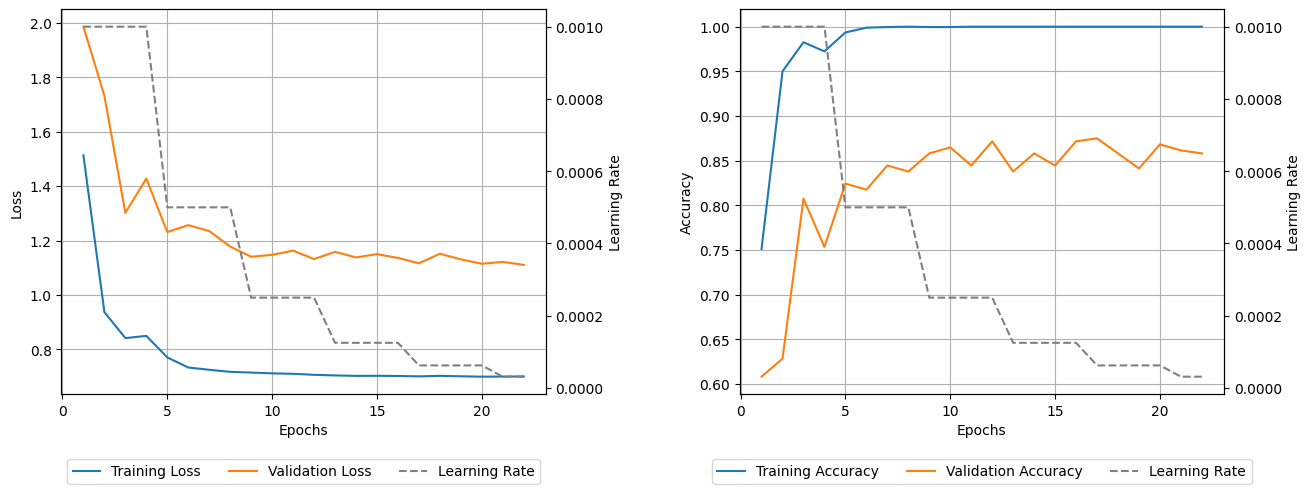

In [57]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
freeze_layers_but(model, ['layer3','layer4','fc']) # <--------------------------
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,
    max_no_improvement_epochs=5

)

We have improved even more our previous results, by achieving $89.5$% on validation accuracy! This confirms that transfer-learning is super efficient if we fine-tune only last layers of our model.  
We're happy with the results!  

Let's save the model!

In [58]:
params = {
    'model': 'ResNet18',
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation, label smoothing, weight decay',
    'unfreezed layers': '[layer3, layer4, fc]',
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_summary.append(params)

In [59]:
torch.save(best_params, "freezed_resnet_best_model.pth")

## Testing our best model
Let's test ResNet18 with our final obtained weights.

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task

model = model.to(device)

best_params = torch.load("freezed_resnet_best_model.pth")

In [61]:
test_model(model, best_params, test_dl)

Test Accuracy: 89.86%
IMPLEMENT PLOT PER CLASS ACCURACY!!!


In [62]:
resnet_summary_df = pd.DataFrame(resnet_summary)
resnet_summary_df.reset_index(drop=True).sort_values(by='validation accuracy', ascending=False)

,model,input size,learning rate,regularization,unfreezed layers,validation accuracy,epoch
4,ResNet18,224,step scheduler,"data augmentation, label smoothing, weight decay","[layer4, fc]",0.885135,16
5,ResNet18,224,step scheduler,"data augmentation, label smoothing, weight decay","[layer3, layer4, fc]",0.875000,17
2,ResNet18,224,step scheduler,"data augmentation, label smoothing, weight decay",None,0.871622,24
1,ResNet18,224,step scheduler,data augmentation,None,0.797297,12
3,ResNet18,224,step scheduler,"data augmentation, label smoothing, weight decay",[fc],0.712838,10
0,ResNet18,64,step scheduler,None,None,0.618243,9


# Visualizing
It is all very good to acheive a high accuracy, but we need to check that something has not gone wrong. We randomely sample from the test set and check our model's output.

In [ ]:
# IMPLEMENT

## Conclusion
In our second study we've concluded that transfer-learning is exploited as it best when we freeze most of the layers of a pre-trained model (the first ones) and we adjust only the last layers.  
This happens because:
- Our model was pre-trained on a very large dataset with respect to our dataset, being already able to extract most of the general features that an image show;
- The last layers are the ones responsible for low-level details which are dataset specific. Fine-tuning only them turned out to improve the accuracy a lot.

Again, we showed how regularization techniques have a huge positive impact on the effectiveness of the training procedure.  

## End of the study